### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

### 1. 광진구 내 쓰레기 배출이 문제가 되는 이유
분석시점인 2020년까지 광진구 내 **가정**에서 발생하는 음식물쓰레기는 줄고 재활용폐기물은 늘었다. 쓰레기 배출과 관련된 민원은 꾸준히 증가했으며 그에 따라 민원 처리량도 늘어났다.
- [공공데이터포털] https://www.data.go.kr/data/3055283/fileData.do

In [ ]:
# 1)음식물쓰레기량이 줄은 이유가 음식물쓰레기 문제의 심각성으로 광진구청이 2015년을 시작으로 폐기물을 줄이는 사업을 펼쳤는지 확인해야 한다.
# 2)음식물쓰레기량이 적게 나타난 것에 RFID 기기로 기존의 음식물쓰레기가 이분화되어 수거되고 있어 나타난 것인지 확인해보니
#   RFID로 수거되는 음식물쓰레기량이 엄청나다. 광진구 내 RFID 수거 방법, 정책에 대해 조사해야 한다.
# 2)늘어난 민원은 재활용폐기물에 의한 것인지 상관계수를 구해본 결과, 0.80으로 매우 강한 상관관계가 있다.
#  즉, 포장지, 일회용품 등의 재활용폐기물 수거가 효율적이지 못한 문제가 발생하고 있다.

In [2]:
housetrash = pd.read_csv('data/서울특별시 광진구_가정폐기물현황_20230131.csv', encoding='cp949')
housetrash['발생년월'] = housetrash['발생년월'].str[:-3]
housetrash.set_index('발생년월', inplace=True)

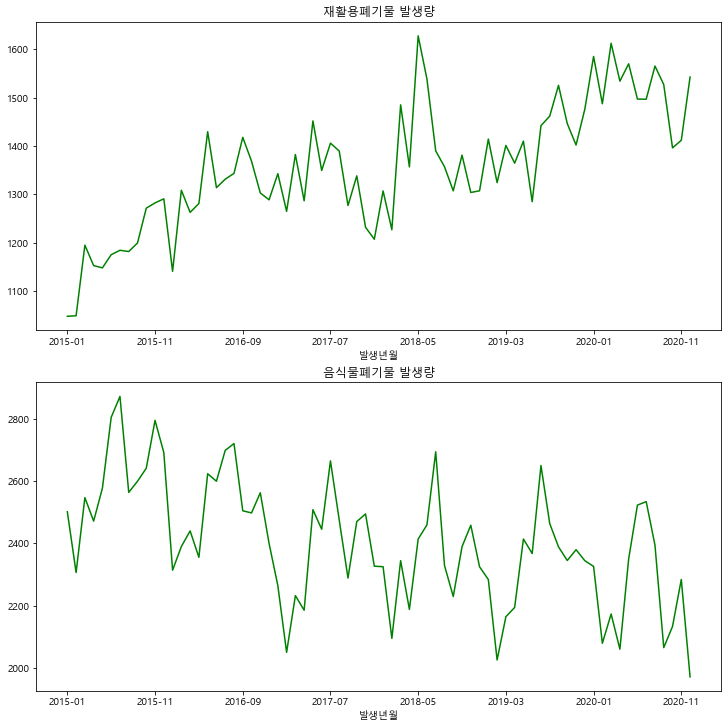

In [3]:
fig, ax = plt.subplots(2,1, figsize=(10,10), constrained_layout=True)
housetrash.loc['2015-01':'2020-12', '재활용폐기물(톤)'].plot(title="재활용폐기물 발생량", ax=ax[0], color='green')
housetrash.loc['2015-01':'2020-12', '음식물폐기물(톤)'].plot(title="음식물폐기물 발생량", ax=ax[1], color='green')
plt.show()

In [4]:
RFID = pd.read_csv('data/한국환경공단_지자체별 RFID음식물쓰레기 배출량_07_31_2020.csv', encoding='cp949')\
       .query('기초지자체=="광진구"')
RFID['발생년월'] = RFID['배출연도'].astype(str) + '-' + RFID['배출월'].astype(str).str.zfill(2)
RFID.set_index('발생년월', inplace=True)

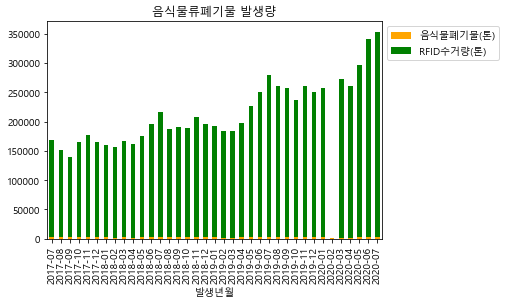

In [5]:
pd.concat([housetrash.loc['2017-07':'2020-07','음식물폐기물(톤)'], RFID['배출량(톤)'].rename('RFID수거량(톤)')], axis=1)\
.plot.bar(title="음식물류폐기물 발생량", stacked=True, color=['orange','green'])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [6]:
complaint = pd.read_csv('data/서울특별시 광진구_쓰레기처리정보_20230203.csv', encoding='cp949')
complaint['신청건수 기준일'] = complaint['신청건수 기준일'].str[:-3]
complaint.set_index(complaint['신청건수 기준일'], inplace=True)

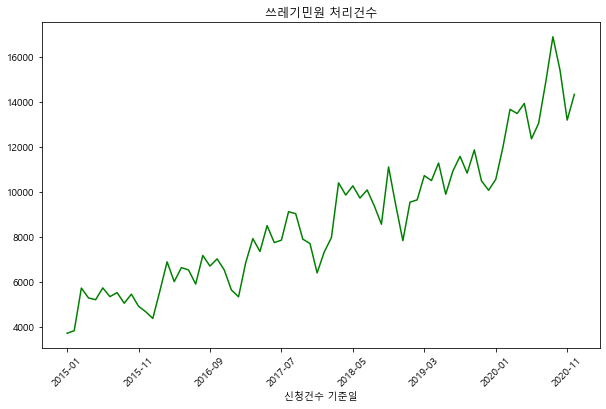

In [7]:
plt.figure(figsize=(10,6))
complaint.loc[:'2020-12','전체 처리건수'].plot(title="쓰레기민원 처리건수", color='green')
plt.xticks(rotation=45)
plt.show()

In [8]:
ease = pd.concat([housetrash.loc['2015-01':'2020-12', '재활용폐기물(톤)'], complaint.loc['2015-01':'2020-12', '전체 처리건수']], axis=1)
print('재활용폐기물과 민원처리건수 간 상관계수:', ease.corr().iloc[0,1])

재활용폐기물과 민원처리건수 간 상관계수: 0.8009627176066199


### 2. 서울특별시 자체구와 비교해 광진구의 어느 쓰레기 배출이 두드러지는 지 확인하자.

In [9]:
seoul = pd.read_csv('data/2020년_서울자치구_비교데이터.csv')
seoul.set_index('자치구', inplace=True)

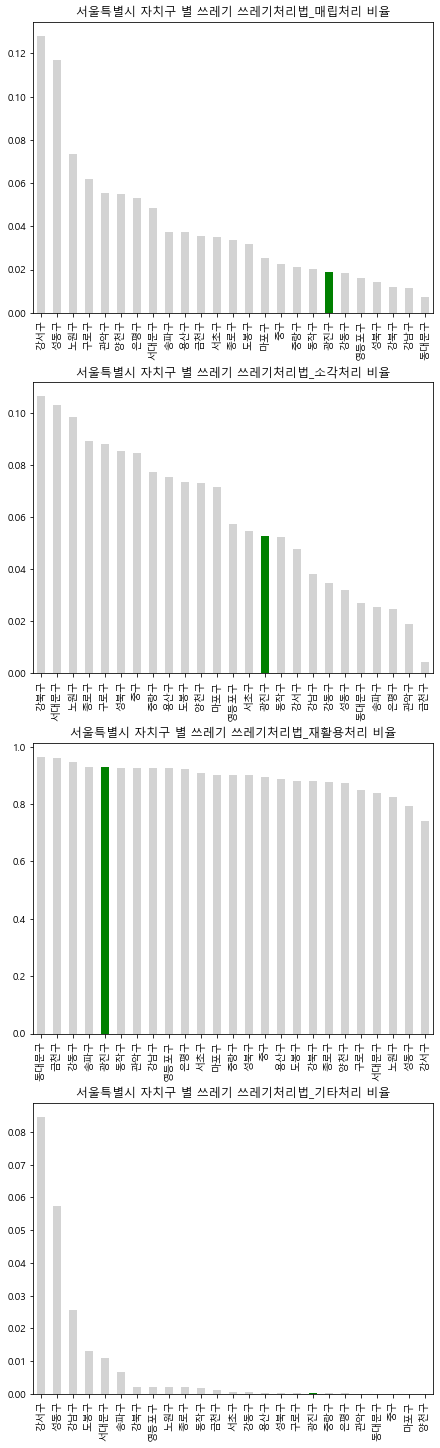

In [10]:
# 대부분의 구와 같이 재활용 비율이 높으며 상위 5위에 해당한다.
ease = seoul[[i for i in seoul.columns if '처리법' in i]].iloc[:,:-3].divide(seoul['쓰레기량'], axis=0)

fig, ax = plt.subplots(4, 1, figsize=(6,20), constrained_layout=True)
for i in range(4):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 쓰레기 {ease.columns[i]}처리 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

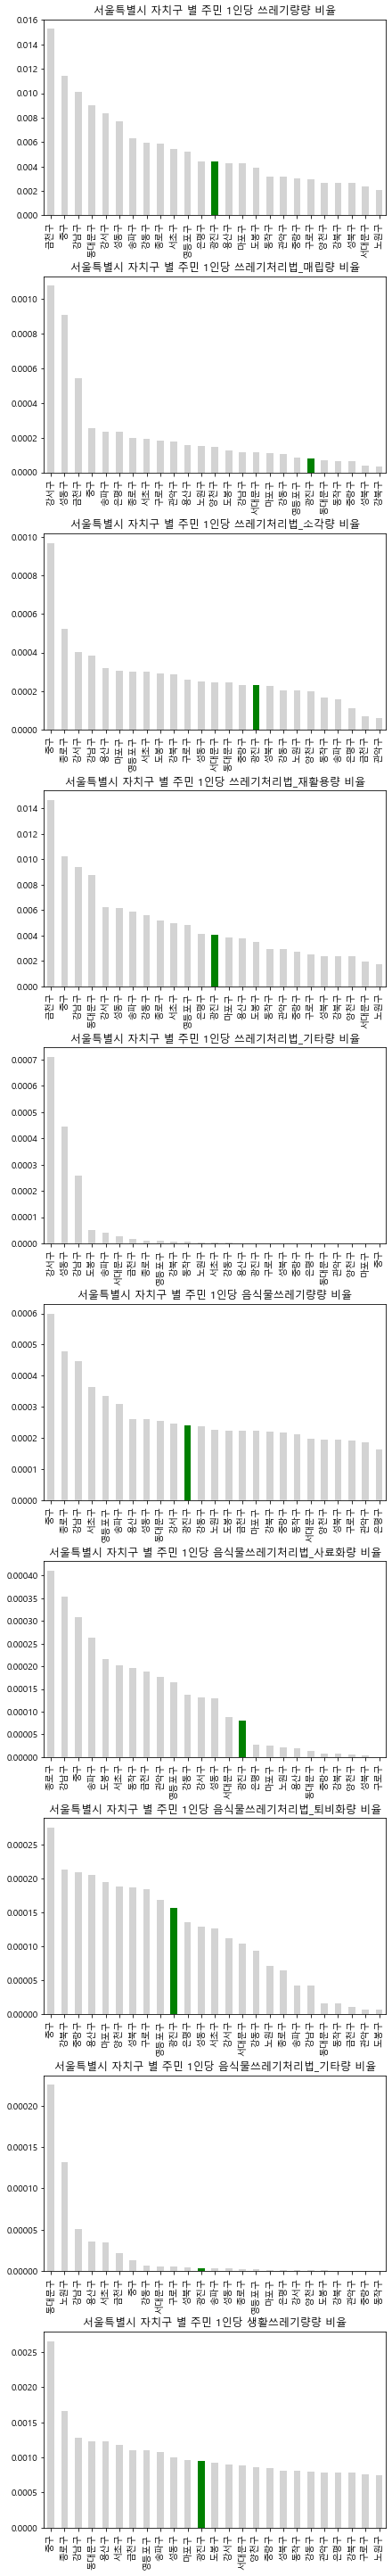

In [11]:
# 발생하는 쓰레기가 앞도적으로 많은 것은 아니다.
ease = seoul[[i for i in seoul.columns if '쓰레기' in i]].divide(seoul['인구'], axis=0)

fig, ax = plt.subplots(10, 1, figsize=(6,40), constrained_layout=True)
for i in range(10):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 주민 1인당 {ease.columns[i]}량 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

In [ ]:
# 특이점을 찾지 못했다.
# ease = seoul[[i for i in seoul.columns if '처리법' in i]].iloc[:,-3:].divide(seoul['음식물쓰레기량'], axis=0)

# fig, ax = plt.subplots(3, 1, figsize=(6,20), constrained_layout=True)
# for i in range(3):
#     color = ['lightgray']*25
#     color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
#     ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 음식물쓰레기 {ease.columns[i]}처리 비율",
#                                                          color=color, ax=ax[i])
#     ax[i].set_xlabel('')
# plt.show()

In [12]:
# 특이점을 찾지 못한 음식물류폐기물에 대해 상세히 알아본다.
foodwaste_cause = pd.read_csv('data/2020년_음식물류폐기물_원인별_배출량.csv')
foodwaste_cause.set_index('자치구', inplace=True)

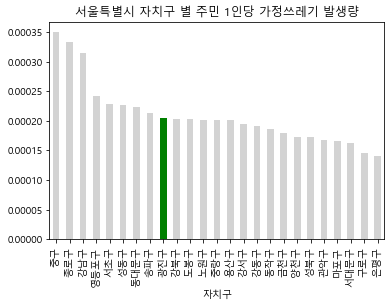

In [13]:
# 주민 1인당 가정쓰레기 발생량은 높지 않은 편이다.
foodwaste_cause['가정'].divide(seoul['인구']).sort_values(ascending=False)\
.plot.bar(title="서울특별시 자치구 별 주민 1인당 가정쓰레기 발생량", color=['lightgray']*8+['green']+['lightgray']*16)
plt.show()

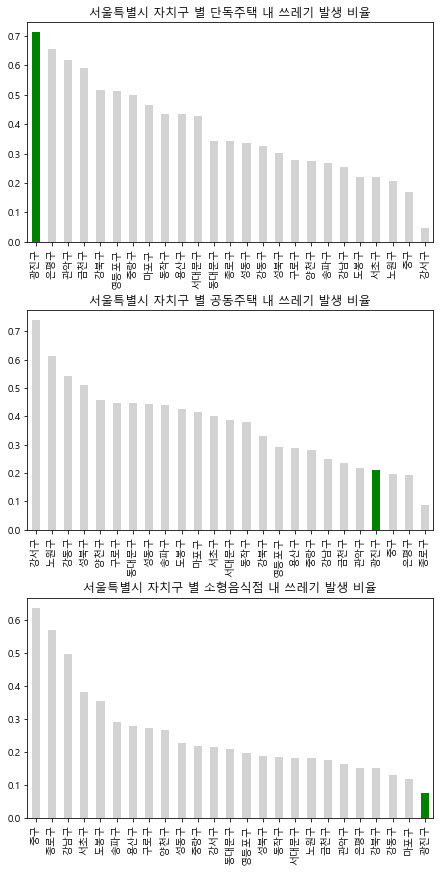

In [14]:
# 그러나 세부적으로 보니 타구에 비해 단독주택에서 발생하는 쓰레기 비율이 높다. 아래에서 보이듯 단독주택 내 다가구주택이 많다.
ease = foodwaste_cause[[i for i in foodwaste_cause.columns if '가정_' in i]].divide(foodwaste_cause['가정'], axis=0)

fig, ax = plt.subplots(3, 1, figsize=(6,12), constrained_layout=True)
for i in range(3):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 {ease.columns[i][3:]} 내 쓰레기 발생 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

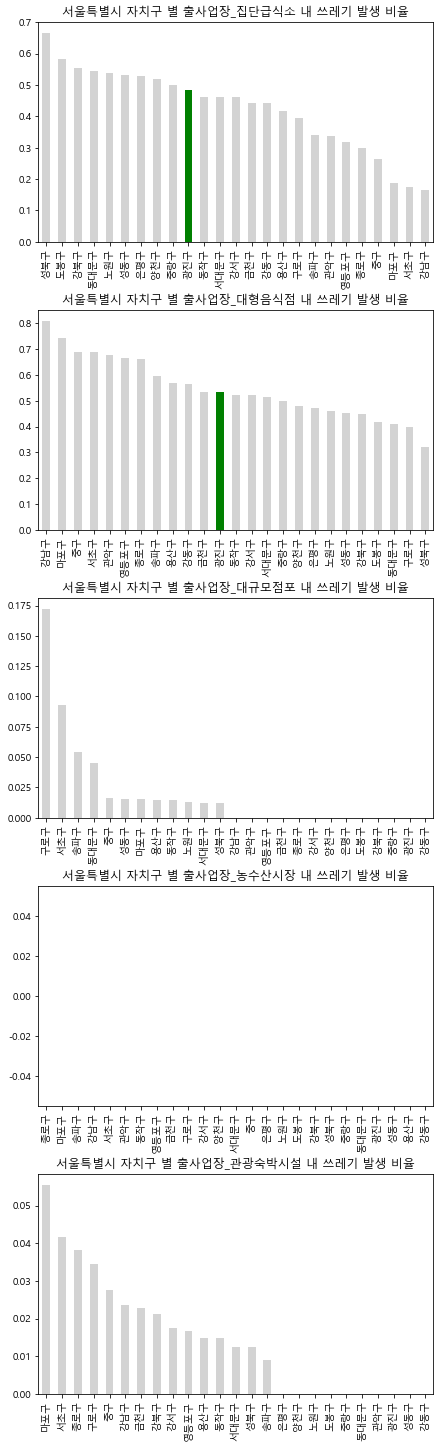

In [44]:
ease = foodwaste_cause[[i for i in foodwaste_cause.columns if '대량배출사업장_' in i]].divide(foodwaste_cause['대량배출사업장'], axis=0)

fig, ax = plt.subplots(5, 1, figsize=(6,20), constrained_layout=True)
for i in range(5):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 {ease.columns[i][3:]} 내 쓰레기 발생 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

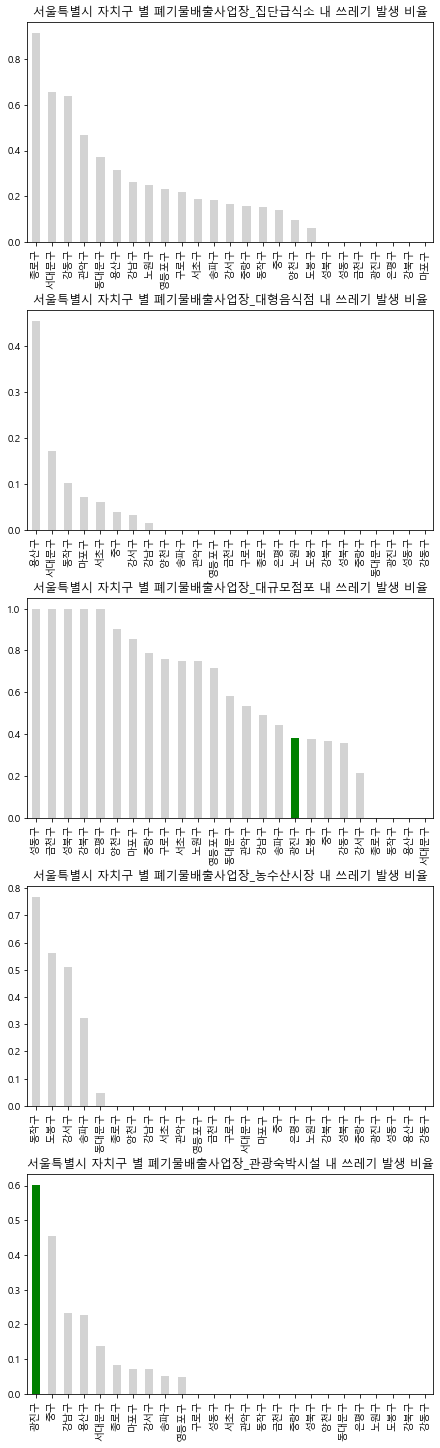

In [45]:
ease = foodwaste_cause[[i for i in foodwaste_cause.columns if '사업장폐기물배출사업장_' in i]]\
       .divide(foodwaste_cause['사업장폐기물배출사업장'], axis=0)

fig, ax = plt.subplots(5, 1, figsize=(6,20), constrained_layout=True)
for i in range(5):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 {ease.columns[i][3:]} 내 쓰레기 발생 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

In [18]:
# 작업 전
# largequantity = pd.read_csv('data/2020년_음식물류폐기물_다량배출업소수.csv')
# largequantity.set_index('자치구', inplace=True)

# foodwaste_cause.columns

# foodwaste_cause['대량배출사업장'].divide(largequantity['다량배출업소수']).sort_values(ascending=False).plot.bar()

# store = pd.read_csv('data/소상공인시장진흥공단_상가(상권)정보_서울_202209.csv', encoding='utf8')

# ease = largequantity['다량배출업소수'].divide(store.groupby('시군구명')['상호명'].size(), axis=0).sort_values(ascending=False)

# store.iloc[:,20:30]

# .iloc[:-8]\
# .plot.bar()

# # 업소 중 
# foodwaste_cause['대량배출사업장'].sort_values(ascending=False).plot.bar()
# #.divide(store.groupby('시군구명')['상호명'].size()).sort_values(ascending=False).plot.bar()

# foodwaste_cause['사업장폐기물배출사업장'].sort_values(ascending=False).plot.bar()

### 3. 서울특별시의 타 구와 어떤 점이 다른가? 어떤 점이 쓰레기 발생 문제의 심각성을 키우는 가?
- 2)데이터가공 > 공공데이터포털_서울특별시자치구.ipynb에서 가공한 데이터이다.

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(18,6))
# seoul['면적'].sort_values(ascending=False).plot.bar(title="서울특별시 자치구 별 면적", ax=ax[0])
# seoul['인구'].sort_values(ascending=False).plot.bar(title="서울특별시 자치구 별 인구", ax=ax[1])
# plt.show()

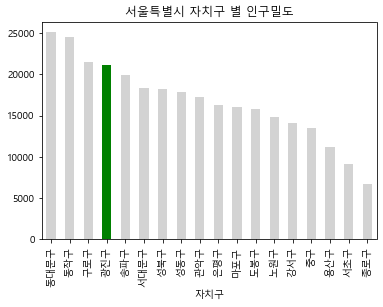

In [13]:
# 광진구는 타구에 비해 구면적보다 인구가 많은, 인구밀도가 높은 지역이다.
seoul['인구밀도'] = seoul['인구'].divide(seoul['면적'])
seoul['인구밀도'].sort_values(ascending=False).plot.bar(title="서울특별시 자치구 별 인구밀도",
                                                        color=['lightgray']*3+['green']+['lightgray']*21)
plt.show()

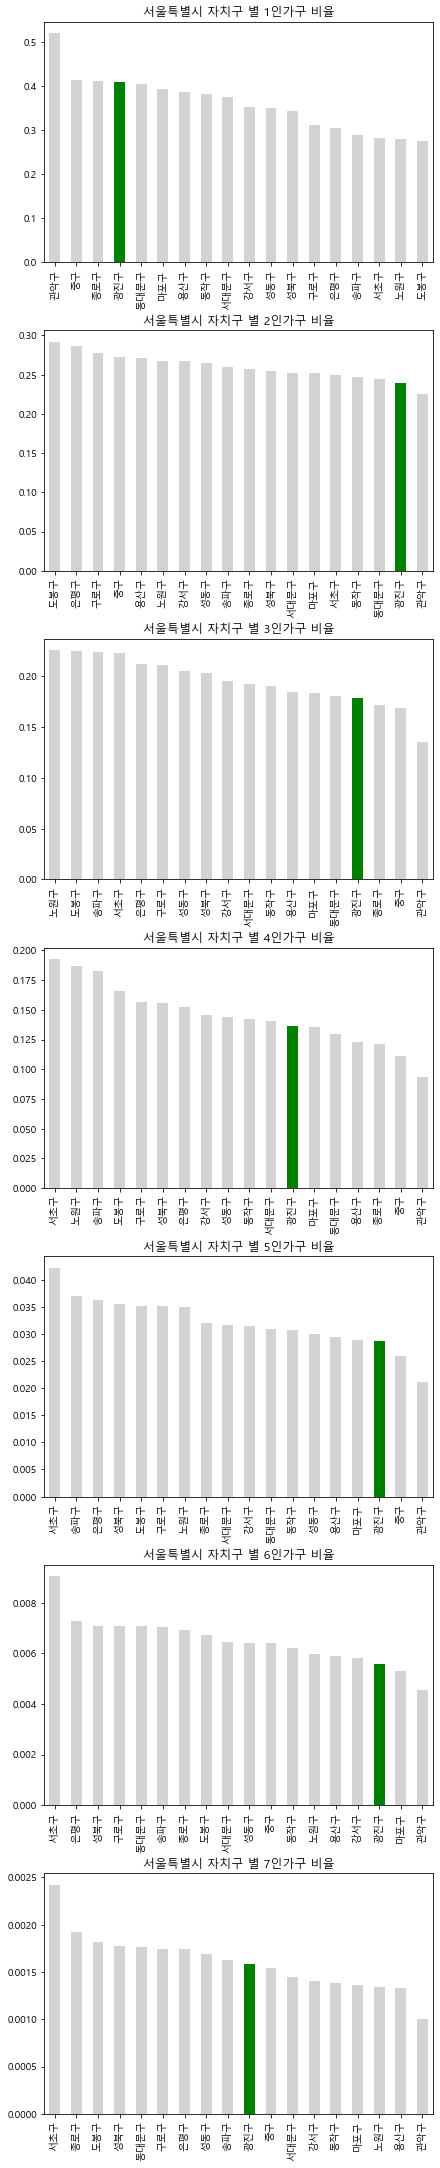

In [127]:
# 광진구는 타구와 달리 1인가구 비율에서만 상위 자치구에 위치한다.
ease = seoul[[i for i in seoul.columns if '가구' in i]].iloc[:,1:-1].divide(seoul['소계'], axis=0)

fig, ax = plt.subplots(7, 1, figsize=(6,30), constrained_layout=True)
for i in range(7):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 {i+1}인가구 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

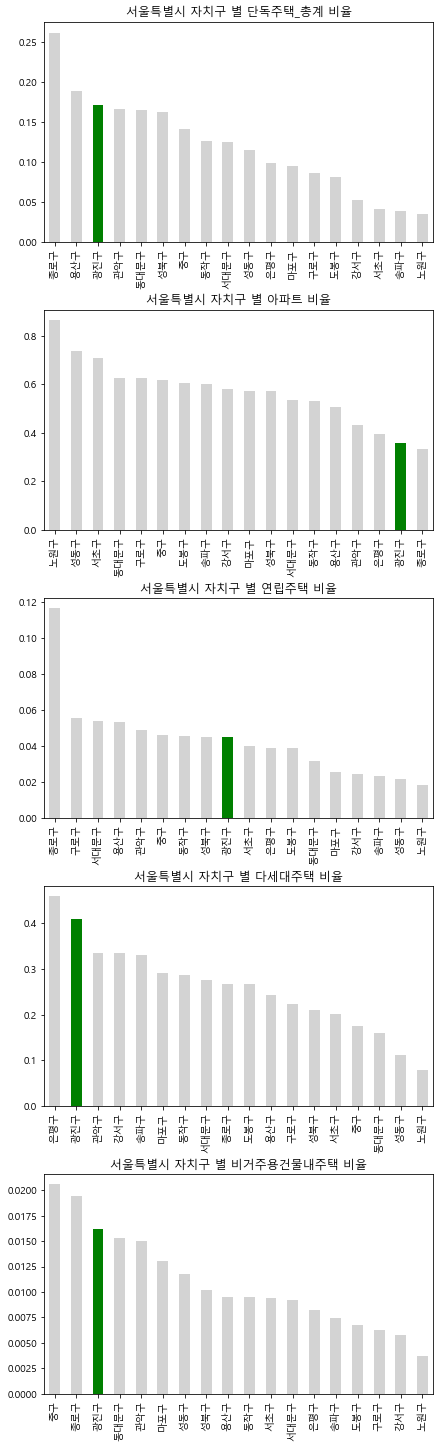

In [128]:
# 광진구는 타구와 달리 단독주택, 다세대주택, 비거주용건물내주택 비율이 높다.
# -> 거주주택수만 분류해 다시 구하면 대학생들이 상주할 것이라 유추되는 단독주택, 다세대주택 비율이 두드러질 것이다.
#    타구와의 차이가 유의한지 평가하기 위한 통계검정을 수행할 수 있다.
ease = seoul[['단독주택_총계','아파트','연립주택','다세대주택','비거주용건물내주택']].divide(seoul['주택수'], axis=0)

fig, ax = plt.subplots(5, 1, figsize=(6,20), constrained_layout=True)
for i in range(5):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 {ease.columns[i]} 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

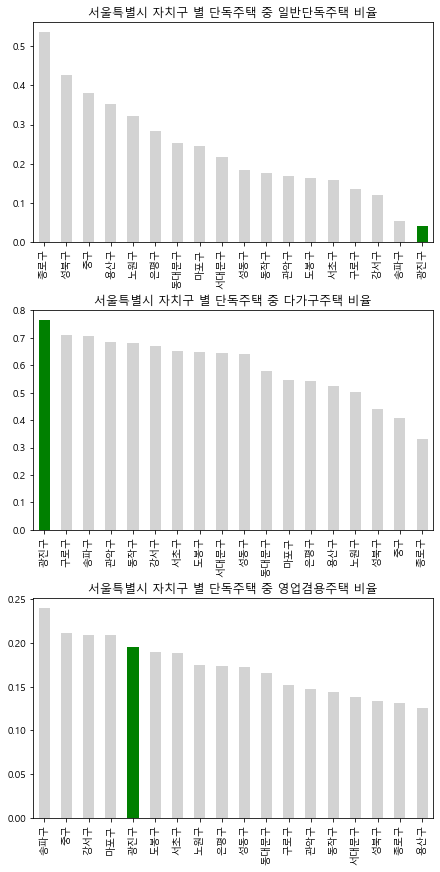

In [130]:
# 광진구는 타구와 차이를 보인 단독주택은 대학생(1인가구, 외국인 등)이 선호하는 다세대 주택의 비율이 압도적으로 높아 상위권을 차지했다.
ease = seoul[['일반단독주택', '다가구주택', '영업겸용주택']].divide(seoul['단독주택_총계'], axis=0)

fig, ax = plt.subplots(3, 1, figsize=(6,12), constrained_layout=True)
for i in range(3):
    color = ['lightgray']*25
    color[ease.iloc[:,i].sort_values(ascending=False).index.tolist().index('광진구')] = 'green'
    ease.iloc[:,i].sort_values(ascending=False).plot.bar(title=f"서울특별시 자치구 별 단독주택 중 {ease.columns[i]} 비율",
                                                         color=color, ax=ax[i])
    ax[i].set_xlabel('')
plt.show()

### 4. 쓰레기가 많이 나오는 행정동, 청소 권역은 어디인가?
- 2)데이터가공 > 제공_쓰레기배출량.ipynb에서 가공한 데이터이다.

In [ ]:
# RFID는 행정동, 광진구청 쓰레기 데이터는 권역별로 작성되어 있다. 범주 기준을 논의해야 한다.
trash = pd.read_csv('data/2020년_광진구_권역별_쓰레기데이터.csv')

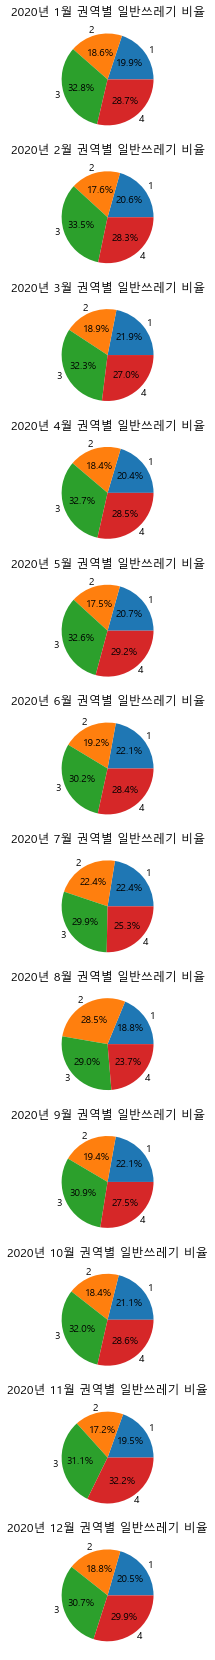

In [57]:
# 권역별 일반쓰레기 비율
# 3구역, 4구역이 압도적으로 높다.
ease = pd.pivot_table(trash, index='구역', columns='월', values='일반쓰레기', aggfunc=sum)

fig, ax = plt.subplots(12,1, figsize=(5,30))
for i in range(12):
    ease.iloc[:,i].plot.pie(title=f'2020년 {i+1}월 권역별 일반쓰레기 비율', autopct='%1.1f%%', ax=ax[i])
    ax[i].set_ylabel('')
    
plt.show()

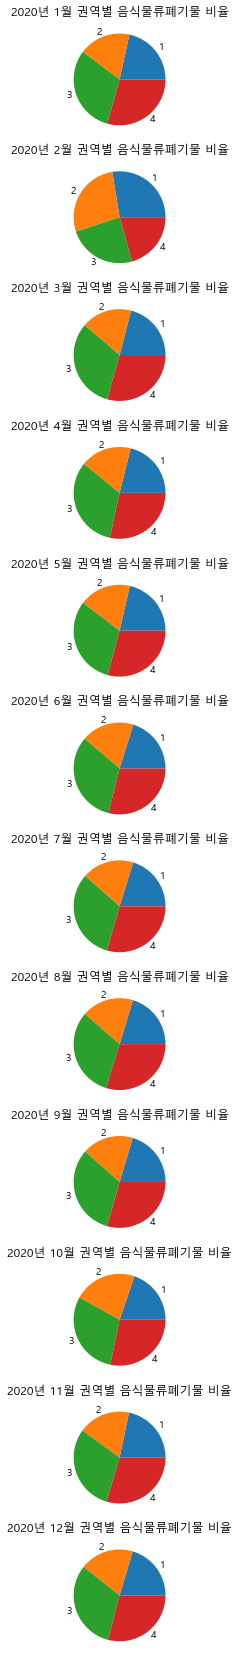

In [51]:
# 권역별 음식물류폐기물 비율
# 2월을 제외하곤 3구역, 4구역이 압도적으로 높다.
ease = pd.pivot_table(trash, index='구역', columns='월', values='음식물류폐기물', aggfunc=sum)

fig, ax = plt.subplots(12,1, figsize=(5,30))
for i in range(12):
    ease.iloc[:,i].plot.pie(title=f'2020년 {i+1}월 권역별 음식물류폐기물 비율', autopct='%1.1f%%', ax=ax[i])
    ax[i].set_ylabel('')
    
plt.show()

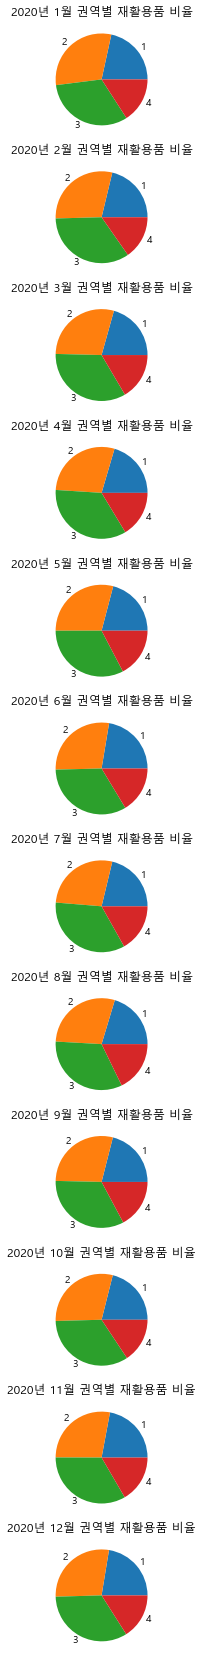

In [54]:
# 권역별 재활용품 비율
# 2구역, 3구역이 압도적으로 높다.
ease = pd.pivot_table(trash, index='구역', columns='월', values='재활용품', aggfunc=sum)

fig, ax = plt.subplots(12,1, figsize=(5,30))
for i in range(12):
    ease.iloc[:,i].plot.pie(title=f'2020년 {i+1}월 권역별 재활용품 비율', autopct='%1.1f%%', ax=ax[i])
    ax[i].set_ylabel('')
    
plt.show()

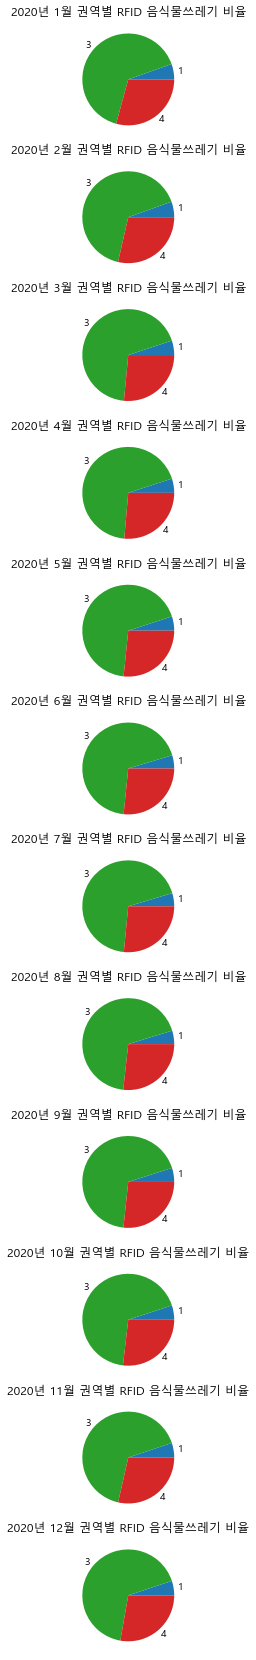

In [55]:
'''권역별 RFID 비율(2구역 행정동의 RFID데이터가 없기에 그려진 그래프이다.)'''
# 3구역이 압도적으로 높다.
ease = pd.pivot_table(trash, index='구역', columns='월', values='RFID', aggfunc=sum)

fig, ax = plt.subplots(12,1, figsize=(5,30))
for i in range(12):
    ease.iloc[:,i].plot.pie(title=f'2020년 {i+1}월 권역별 RFID 음식물쓰레기 비율', autopct='%1.1f%%', ax=ax[i])
    ax[i].set_ylabel('')
    
plt.show()

### 4. 구내 청소권역별 특징은 무엇인가?
- [특징1] https://www.data.go.kr/data/15034360/fileData.do
- [특징5] https://www.data.go.kr/data/15083033/fileData.do

In [ ]:
'''아래 음식물폐기물다량배출사업장 데이터에 대부분의 학교들이 다량배출장으로 작성되어있다.
   우리의 분석 주제는 개인의 소비로 인해 쓰레기가 무분별하게 배출되고 그로인한 수거 문제로 발생한 피해를 줄이고자 
   쓰레기양을 예측, 효율적 수거방안 제안하는 것으로 집단급식소는 분석에서 제외시켰다.'''

In [ ]:
area = dict(zip(['중곡1동','중곡2동','군자동','능동'],[1]*4))
area.update(zip(['중곡3동','중곡4동','구의2동'],[2]*3))
area.update(zip(['구의1동', '구의3동','광장동','화양동'],[3]*4))
area.update(zip(['자양1동', '자양2동', '자양3동', '자양4동'],[4]*4))

In [68]:
# 특징1. 음식물폐기물을 많이 배출하는 식당은 3권역에 집중되어 있다.
plenty = pd.read_csv('2stData/서울특별시 광진구_음식물폐기물다량배출사업장 현황_20230223.csv', encoding='cp949')
plenty.drop(plenty[plenty['구 분']=="집단급식소"].index.tolist()+plenty[plenty['구 분']=='관광숙박시설'].index.tolist(),
            inplace=True)
plenty['구역'] = plenty['행정동'].map(area)

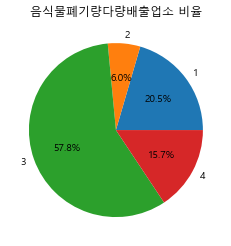

In [106]:
plenty['구역'].value_counts().sort_index().plot.pie(title="음식물폐기량다량배출업소 비율", autopct='%1.1f%%')
plt.ylabel('')
plt.show()

In [ ]:
# 특징2, 특징3, 특징4에 사용할 빅데이터캠퍼스 데이터가 승인이 나지 않았다.

In [121]:
# 특징5. 타권역에 비해 1권역은 생활서비스, 2권역은 소매, 3권역은 음식 상권이 많다.
store = pd.read_csv('2stData/소상공인시장진흥공단_상가(상권)정보_서울_202209.csv', encoding='utf8', 
                    usecols=[1,4,6,8,10,14,16,37,38]).query("시군구명=='광진구'").reset_index(drop=True)
store['구역'] = store['행정동명'].map(area)

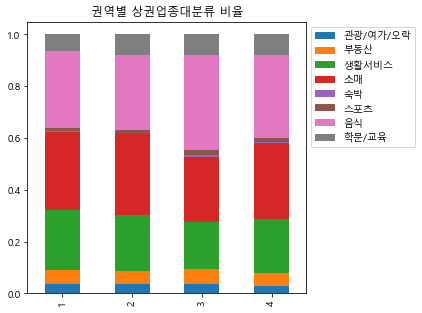

In [132]:
ease = pd.pivot_table(store, index='구역', columns='상권업종대분류명', values='상호명', aggfunc=np.size, margins=True)
ease.divide(ease['All'], axis=0).iloc[:-1,:-1].plot.bar(title="권역별 상권업종대분류 비율", figsize=(5,5),stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('')
plt.show()

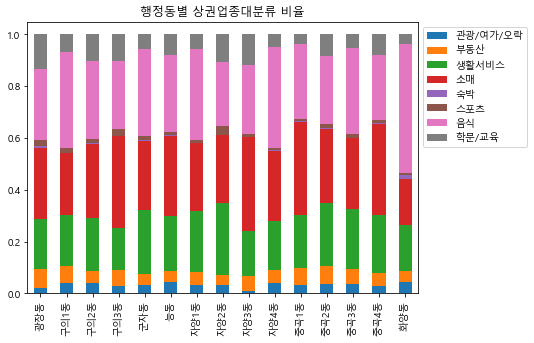

In [129]:
# 특히, 3권역의 화양동에 음식점이 많다. 
ease = pd.pivot_table(store, index='행정동명', columns='상권업종대분류명', values='상호명', aggfunc=np.size, margins=True)
ease.divide(ease['All'], axis=0).iloc[:-1,:-1].plot.bar(title="행정동별 상권업종대분류 비율", figsize=(7,5),stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('')
plt.show()

In [ ]:
# 1인 가구 데이터 현지에게 물어보기

In [ ]:
# https://bdp.kt.co.kr/invoke/SOKBP2603/?goodsCode=KGUPOPLTNINFO
# 현지가 사용한 배달 데이터 물어보기(SKT 통신), 카드소비, 온라인주문 등

### 5. 쓰레기 배출량 예측에 유의한 Feature를 선별한다.

In [ ]:
'''쓰레기가 무분별하게 발생하는 지역을 찾고 효율적 수거를 위한 방법을 제안하자.
- 쓰레기배출량을 예측해서 무분별한 지역을 선별한다. 
  -> Sample수에 따라 통계적인 방법으로 예측해야 하고, 1인가구나 인구밀도, 단독주택 비율 등으로 다중회귀모형을 만들자.
    (월별 값을 구할 수 있는 데이터가 필요하다. 월별로 산출할 수 있는 데이터를 찾아 공유하자.
     월별 혹은 분기별로 묶어 설명모델을 만들면 다음 월/분기의 쓰레기 수거 예산, 인력 배치 등에 활용할 수 있다는 이점이 있다.
     연도별 예측을 하면 Feature를 만드는데 사용할 데이터는 많을 것이나 예측을 수행해봤자 
     특정 년도의 광진구에 발생할 쓰레기량을 예측하는 것에 불과해 광진구 **내** 쓰레기 배출이 무분별한 구역을 꼽을 수 없다.)
  => 예측을 포기하기 지수 만들기로 전환한다. 쓰레기 발생량에 영향을 미친 Feature들, 1인가구나 인구밀도, 단독주택 비율로 
     1)지수를 만들고 만든 지수로 2)실제 쓰레기 증감에 어떤 설명력을 제시했는지 증명해 효용성을 언급한다. 
     개발한 지수값과 3)상권명, 특정 거리를 DashBoard에 기입해 예상되는 쓰레기 증감에 관해 
     어떤 곳을 광진구청 입장에서 중점을 둬야하는 지 알린다.
     # 골목상권 별 속성이 쓰레기 발생과 연관성이 있는지 **입증**하고 입증되면 중점을 둬야하는 골목상권도 안내하도록 한다.
     
- 현지는 주택 분포로부터 밀집된 곳에 쓰레기통을 배치하길, 쓰레기장 배치 지점을 제안하는 아이디어를 준비했다.
  광진구 청소과 담당자가 말했듯 쓰레기 배출일이 지켜지지 않는 것을 문제로 꼽았는데
  특정 일에 맞춰 집에 쓰레기를 쌓아 두다가 배출한다는 것은 말이 되지 않는다. 주민들은 쓰레기를 수거하는 곳에 일단 두고 
  수거일에 맞춰 수거될 것이라 생각한다. 이로인해 골목에 쓰레기가 늘고 냄새, 미관 등의 문제가 생기는 것이다.
  주택의 분포로 수거일에 쓰레기가 수거될 때까지 쓰레기를 모아 둘, 쓰레기장의 위치를 제안하자.
- 쓰레기 배출 위험지수를 바탕으로 입지 후보별 시급성, 중요성과 권역별 쓰레기장 개수를 판단해 신설/보수 등을 결정할 수 있을 것이다.
  쓰레기장 내 RFID 기기 설치 등을 제안한다.
- 상우오빠는 흡연이 많이 이루어지는 골목에 쓰레기 배출까지 이루어지면 인식이 나빠질 것이기에 흡연이 많이 이루어진 지역을
  지수의 Feature로 쓸 수 있다. 흡연지역 중 개방 흡연지와 쓰레기 배출량 간 상관관계를 입증 후 Feature로 사용한다.
'''

### To Do
- 지수를 개발할 중요한 설명변수, 주민 1인당 쓰레기양이 많이 나타난 곳의 단독주택수, 다가구주택 비율 등을 근거로 하여 지수의 설명변수로 구역별 단독주택수, 1인가구비율 등을 구한다.<br>
  1)`2015년~2020년까지의 연단위 재활용폐기물량, 음식물류폐기물량(독립변수1)과 지수에 사용하려고 상관성을 입증하려는 연단위 단독주택수, 1인가구 비율 등(독립변수2) 간 상관관계를 보아 지수의 산출변수 근거로 삼는다.` 광진구에 대응하는 데이터만이 아닌 보편성을 갖추도록, 서울특별시 모든 혹은 유사 자치구 데이터를 사용하여 입증한다.(데이터수가 많아서 훨씬 좋음) <br>
  2)2020년 청소권역별 쓰레기배출량(독립변수1)과 청소권역별 단독주택수, 1인가구 비율 등(독립변수2) 간 상관관계를 보아 지수의 산출변수 근거로 삼는다. 이 경우, 월별 독립변수2를 산출할 수 있어야 하거나 단순 숫자 변화로만 확인할 수 있다.
- 지수 개발 사례를 찾아보고 지수 개발할 기법, 요인분석이나 PCA 등을 연구해 구해볼 지수의 설명변수 후보를 추리고 상관성을 입증해 확보한다.

In [ ]:
# 설명변수 찾기 -> 서경, 현지
# 상관기법과 지수개발 사례 찾기, 지수 산출후보 추천! -> 상우

In [ ]:
# Ready)월별 쓰레기 배출량을 예측하고자 한다면 대응되게 월별 인구, 유학생수 변화, 주택수 변화 등의 데이터가 있어야 한다.
# 1. RFID로 수거되는 음식물류폐기물은 별도로 행정동으로 예측해야 한다. 결측치인 행정동은 어떻게 처리할 지 논의하기.
# 2. 광진구청에서 제공한 보고서를 바탕으로 청소업체별로 일반쓰레기와 음식물쓰레기에 따라 담당하는 행정동이 상이하기에 별도로 예측해야 한다.